In [7]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import sys

# Import Sionna
try:
    import sionna
except ImportError as e:
    # Install Sionna if package is not already installed
    import os
    os.system("pip install sionna")
    import sionna
    
from sionna.utils import BinarySource, QAMSource, ebnodb2no, compute_ser, compute_ber, PlotBER
from sionna.channel import FlatFadingChannel, KroneckerModel
from sionna.channel.utils import exp_corr_mat
from sionna.mimo import lmmse_equalizer
from sionna.mapping import SymbolDemapper, Mapper, Demapper
from sionna.fec.ldpc.encoding import LDPC5GEncoder
from sionna.fec.ldpc.decoding import LDPC5GDecoder

In [8]:
# Configure the notebook to use only a single GPU and allocate only as much memory as needed
# For more details, see https://www.tensorflow.org/guide/gpu
import tensorflow as tf
gpus = tf.config.list_physical_devices('GPU')
print('Number of GPUs available :', len(gpus))
if gpus:
    gpu_num = 0 # Number of the GPU to be used
    try:
        tf.config.set_visible_devices(gpus[gpu_num], 'GPU')
        print('Only GPU number', gpu_num, 'used.')
        tf.config.experimental.set_memory_growth(gpus[gpu_num], True)
    except RuntimeError as e:
        print(e)

Number of GPUs available : 1
Only GPU number 0 used.


(1, 4, 1, 1824)
(1, 4, 1, 1824)
BER: 0.0 at Eb/No of 0 dB and 7296 simulated bits


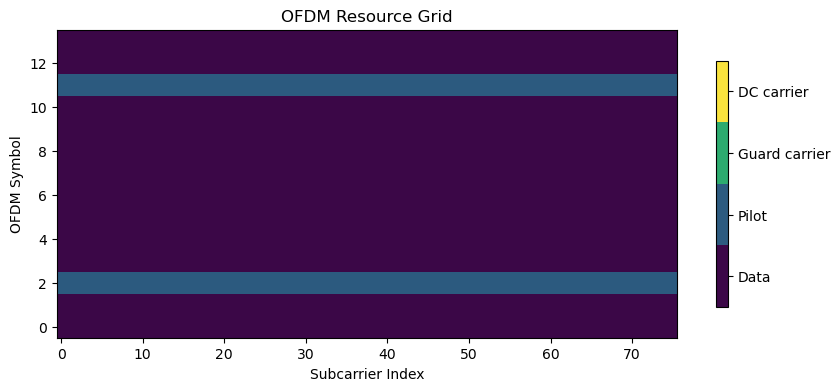

In [9]:
# Commented out IPython magic to ensure Python compatibility.
from scipy import constants
import tensorflow as tf
import numpy as np

try:
    import sionna as sn
except ImportError as e:
    # Install Sionna if package is not already installed
    import os
    os.system("pip install sionna")
    import sionna as sn

# For plotting
# %matplotlib inline
import matplotlib.pyplot as plt

# For the implementation of the Keras models
from tensorflow.keras import Model

NUM_UT = 4
NUM_BS = 1
NUM_UT_ANT = 1
NUM_BS_ANT = 64

NUM_STREAMS_PER_TX = NUM_UT_ANT

RX_TX_ASSOCIATION = np.array([[1, 1, 1, 1]])

STREAM_MANAGEMENT = sn.mimo.StreamManagement(RX_TX_ASSOCIATION, NUM_STREAMS_PER_TX)

RESOURCE_GRID = sn.ofdm.ResourceGrid(num_ofdm_symbols=14,
                                      fft_size=76,
                                      subcarrier_spacing=30e3,
                                      num_tx=NUM_UT,
                                      num_streams_per_tx=NUM_STREAMS_PER_TX,
                                      cyclic_prefix_length=6,
                                      pilot_pattern="kronecker",
                                      pilot_ofdm_symbol_indices=[2,11])
RESOURCE_GRID.show();

NUM_BITS_PER_SYMBOL = 2 # 4-QAM
CODERATE = 0.5
n = int(RESOURCE_GRID.num_data_symbols*NUM_BITS_PER_SYMBOL)
k = int(n*CODERATE)

binary_source = sn.utils.BinarySource()

mapper = sn.mapping.Mapper("qam", NUM_BITS_PER_SYMBOL)

rg_mapper = sn.ofdm.ResourceGridMapper(RESOURCE_GRID)

rayleigh = sn.channel.RayleighBlockFading(NUM_BS, NUM_BS_ANT, NUM_UT, NUM_UT_ANT)

channel = sn.channel.OFDMChannel(rayleigh, RESOURCE_GRID, add_awgn=True, normalize_channel=True, return_channel=True)

ls_est = sn.ofdm.LSChannelEstimator(RESOURCE_GRID, interpolation_type="nn")

lmmse_equ = sn.ofdm.LMMSEEqualizer(RESOURCE_GRID, STREAM_MANAGEMENT)

demapper = sn.mapping.Demapper("app", "qam", NUM_BITS_PER_SYMBOL, hard_out="True")

ebno_db = 0

no = sn.utils.ebnodb2no(ebno_db=ebno_db,
                        num_bits_per_symbol=NUM_BITS_PER_SYMBOL,
                        coderate=CODERATE,
                        resource_grid=RESOURCE_GRID)

BATCH_SIZE = 1

# Transmitter
bits = binary_source([BATCH_SIZE, NUM_UT, RESOURCE_GRID.num_streams_per_tx, k*2])
print(bits.shape)
x = mapper(bits)
x_rg = rg_mapper(x)

# Channel
y, h_freq = channel([x_rg, no])

# Receiver
h_hat, err_var = ls_est ([y, no])
x_hat, no_eff = lmmse_equ([y, h_hat, err_var, no])
llr = demapper([x_hat, no_eff])
print(llr.shape)

ber = sn.utils.metrics.compute_ber(bits, llr)
nb_bits = np.size(bits.numpy())

print("BER: {:.4} at Eb/No of {} dB and {} simulated bits".format(ber.numpy(), ebno_db, nb_bits))